In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

In [ ]:
cifar = keras.datasets.cifar10

(X_train, y_train), (X_test, y_test) = cifar.load_data()

In [ ]:
X_train = tf.cast(X_train, dtype=tf.float32) / 255.
X_test = tf.cast(X_test, dtype=tf.float32) / 255.

Generator and discriminator build

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

keras.backend.clear_session()

codings_size = 100

generator = keras.models.Sequential([
                    keras.layers.Dense(8 * 8 * 128, input_shape=[codings_size]),
                    keras.layers.Reshape([8, 8, 128]),
                    keras.layers.BatchNormalization(),
                    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same',
                                                 activation='selu'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                                        activation='tanh')
])

discriminator = keras.models.Sequential([
                    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same',
                                        activation=keras.layers.LeakyReLU(0.2), input_shape=[32, 32, 3]),
                    keras.layers.Dropout(0.4),
                    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same',
                                        activation=keras.layers.LeakyReLU(0.2)),
                    keras.layers.Dropout(0.4),
                    keras.layers.Flatten(),
                    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [ ]:
X_gan = tf.reshape(X_train, [-1, 32, 32, 3]) * 2. - 1.

Prepare dataset

In [ ]:
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(X_gan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    images = (images + 1.) / 2.
    if images.shape[-1] == 1:
        images = np.squeeze(images)
    plt.figure(figsize=(2 * n_cols, 2 * n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, interpolation='nearest')
        plt.axis('off')

Train function to GAN

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=10):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, n_cols=8)
        plt.show()

Epoch 1/20


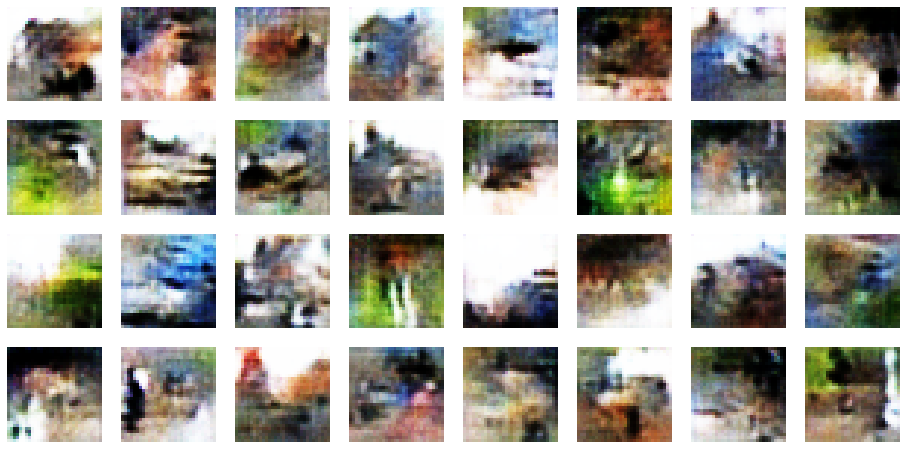

Epoch 2/20


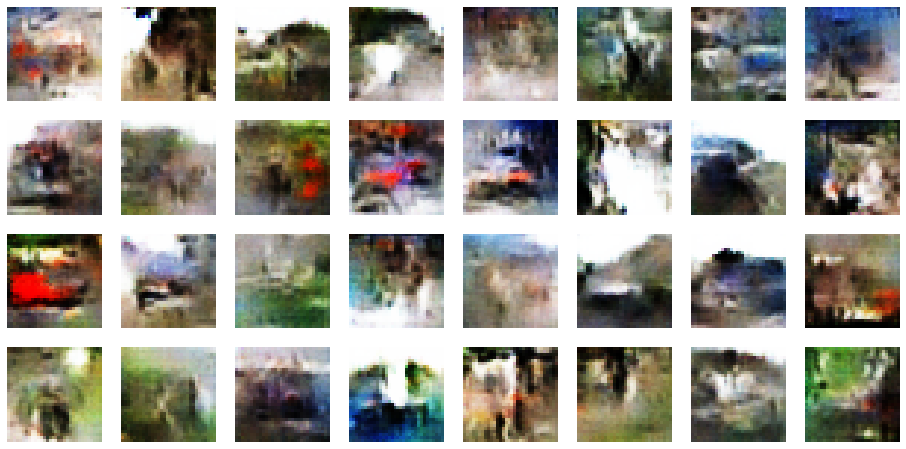

Epoch 3/20


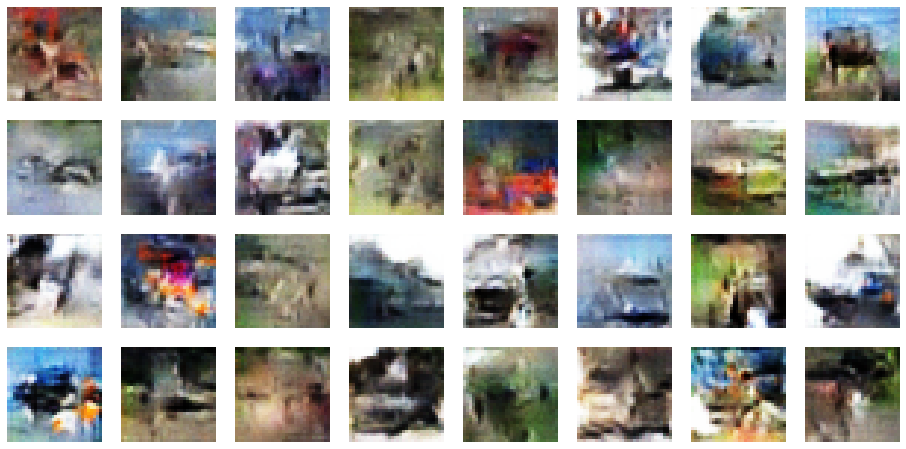

Epoch 4/20


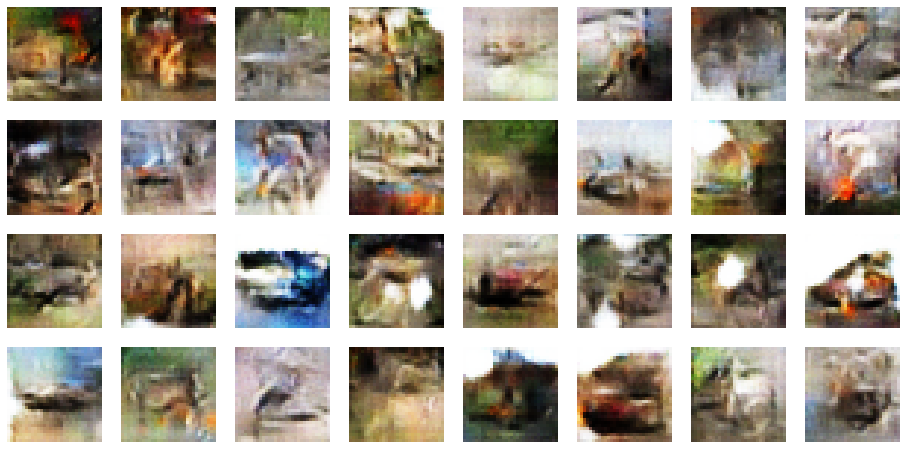

Epoch 5/20


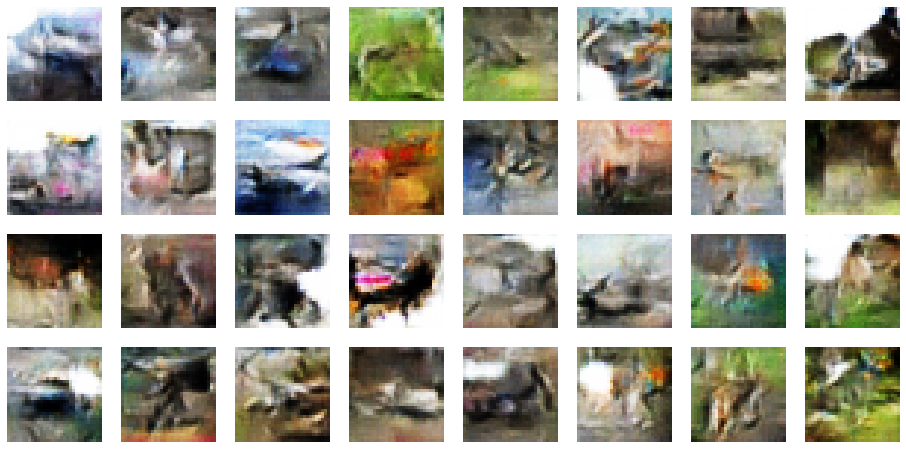

Epoch 6/20


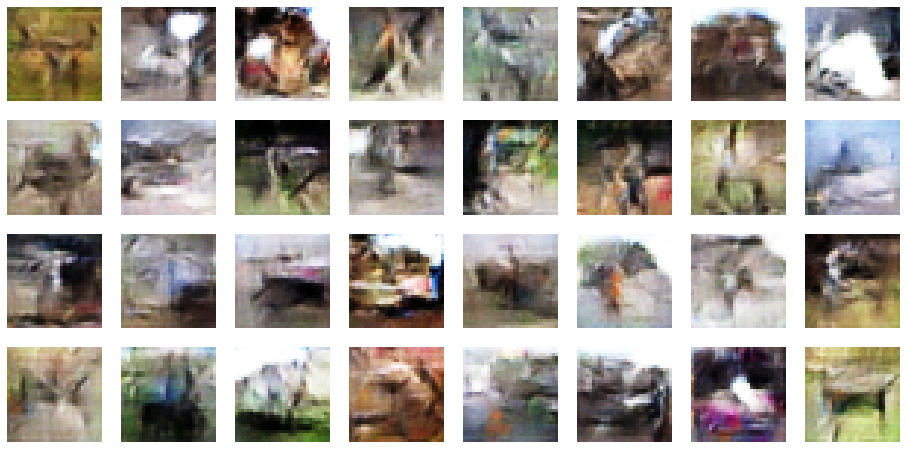

Epoch 7/20


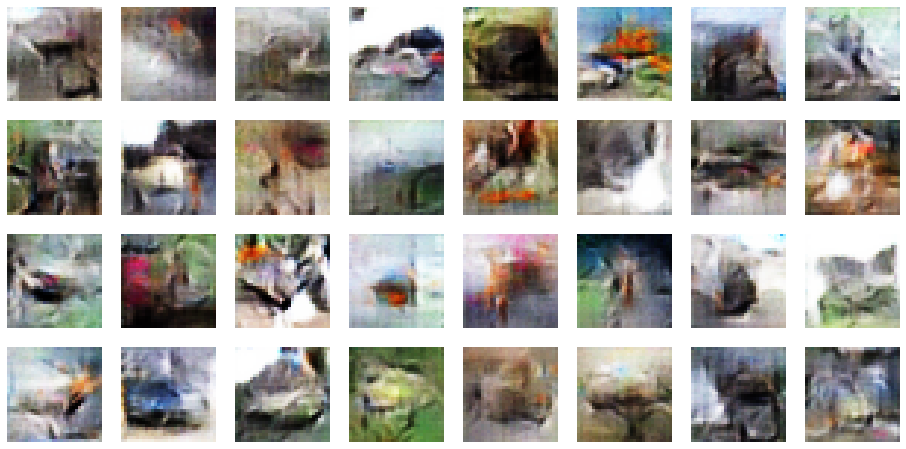

Epoch 8/20


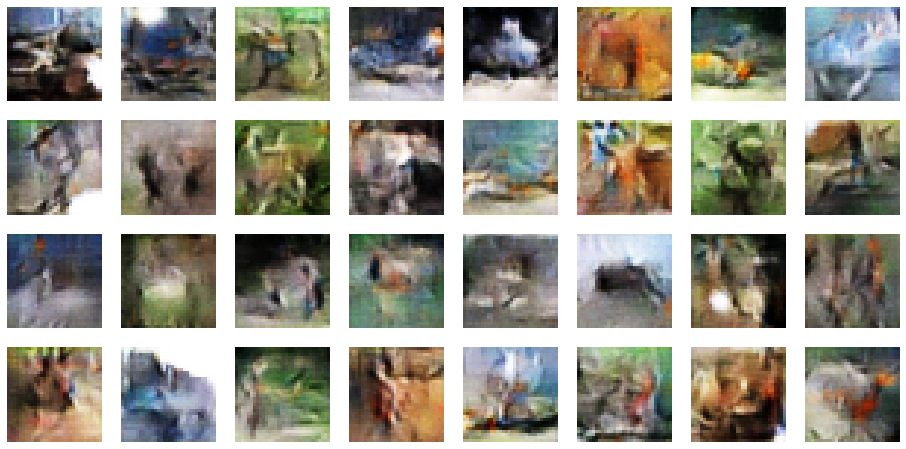

Epoch 9/20


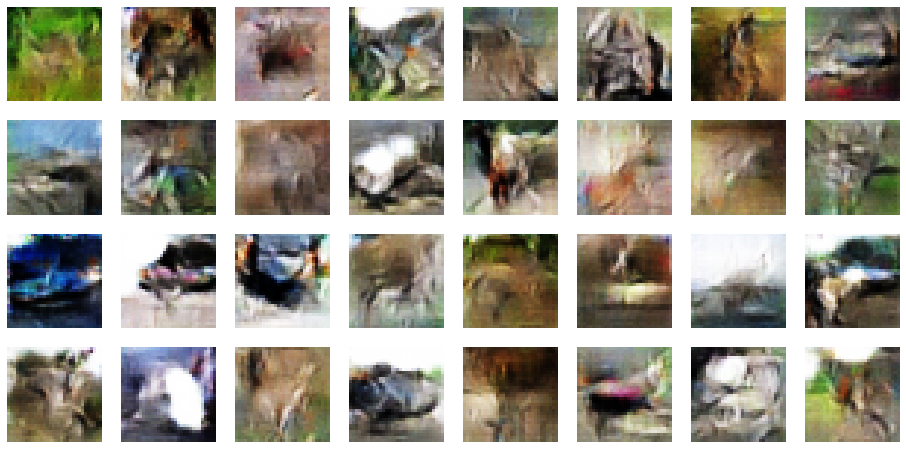

Epoch 10/20


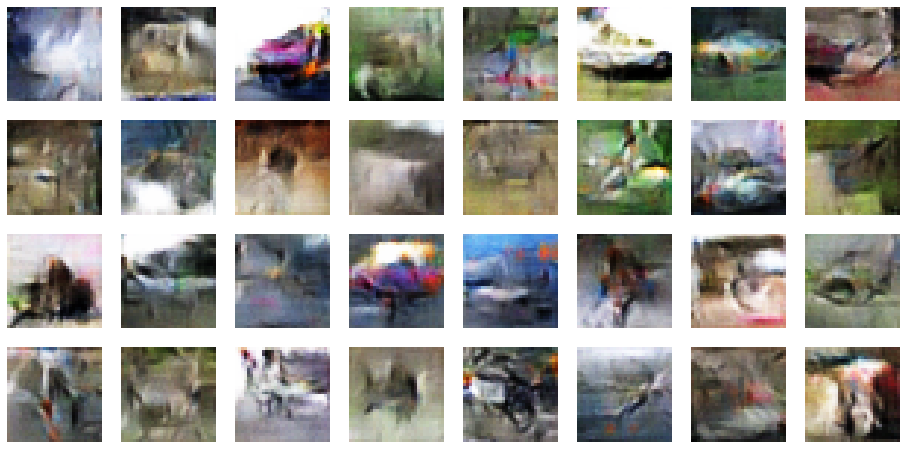

Epoch 11/20


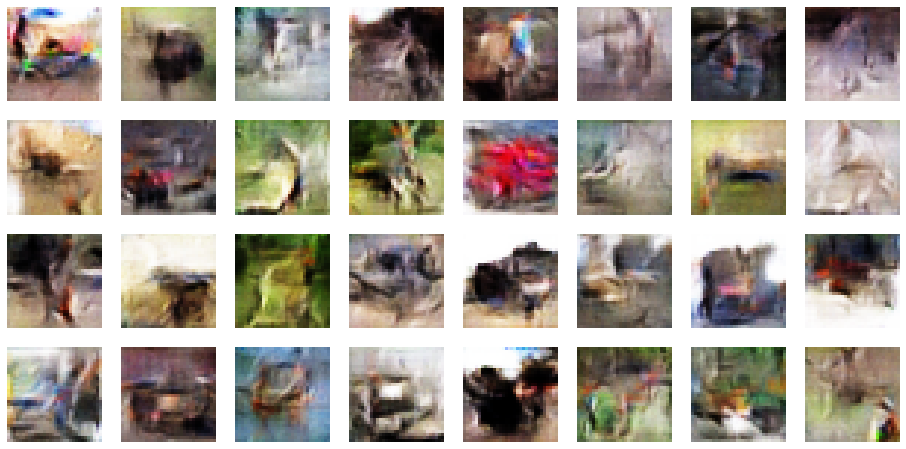

Epoch 12/20


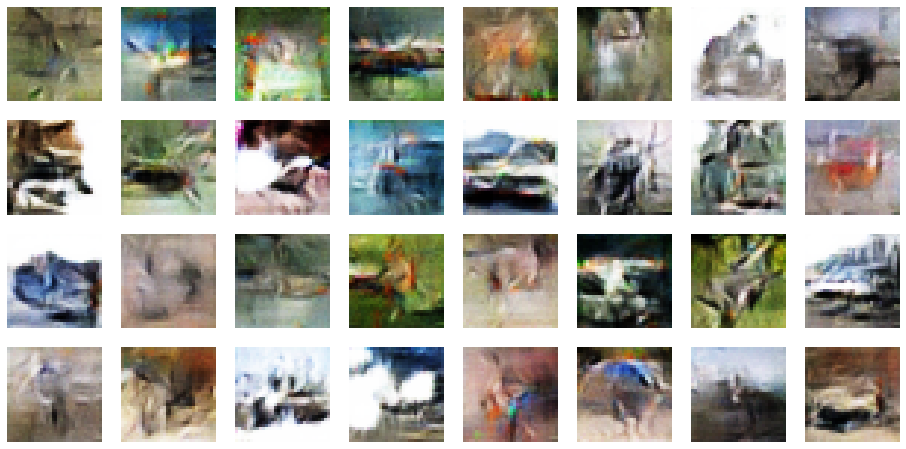

Epoch 13/20


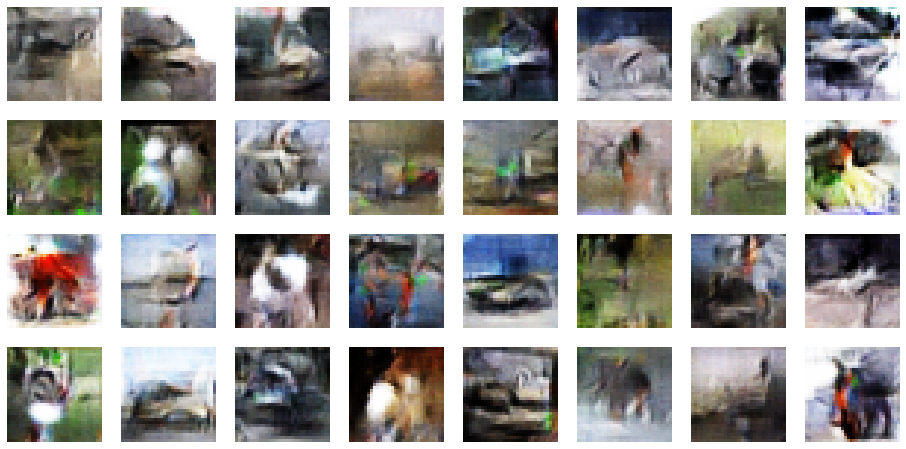

Epoch 14/20


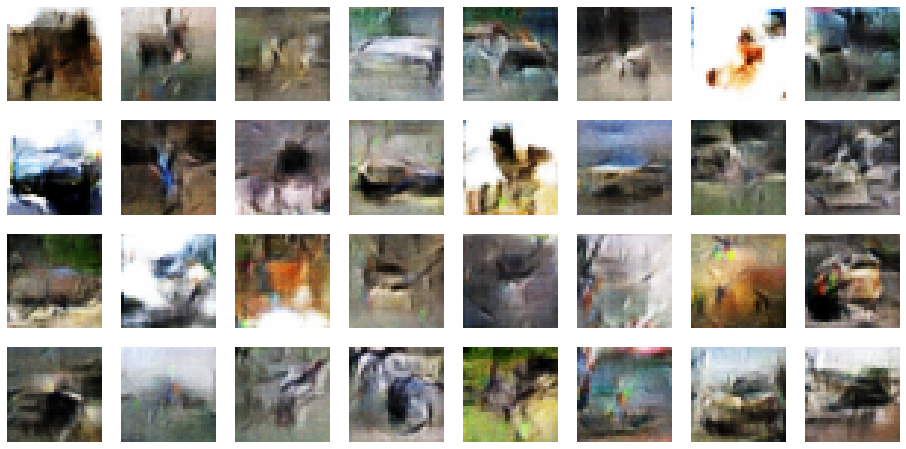

Epoch 15/20


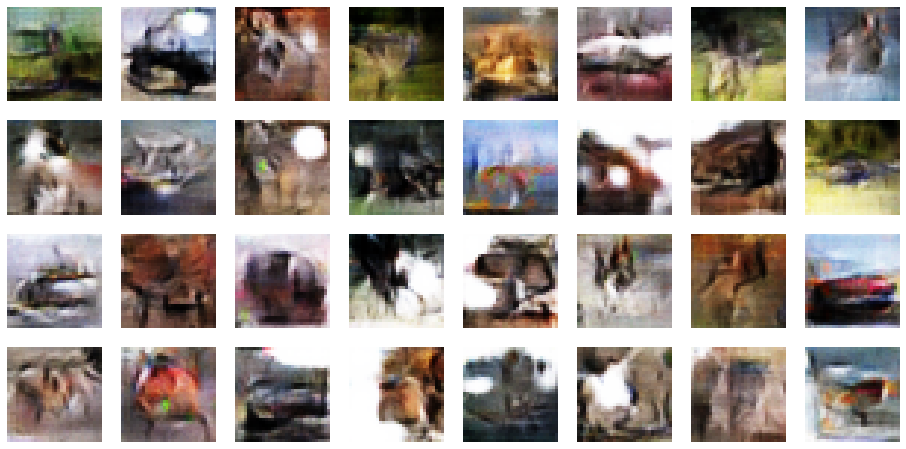

Epoch 16/20


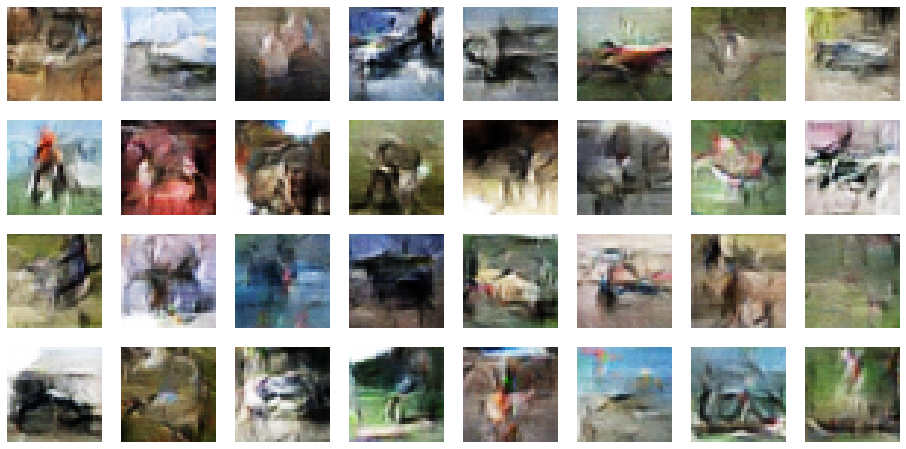

Epoch 17/20


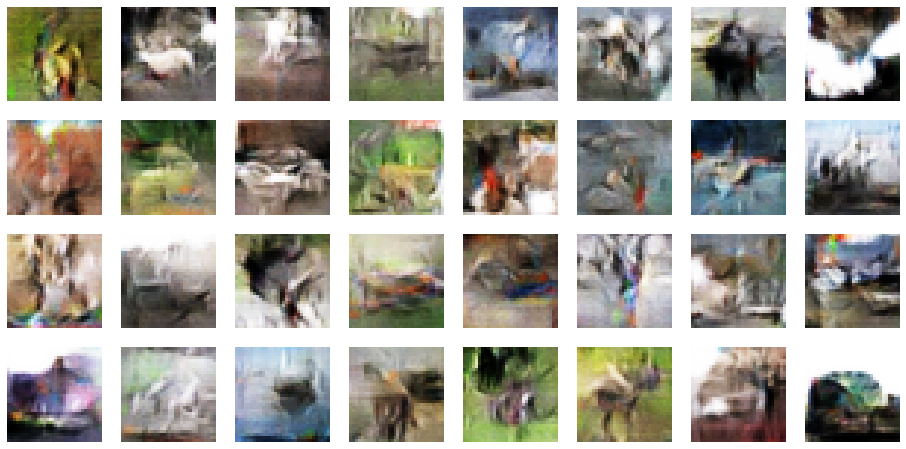

Epoch 18/20


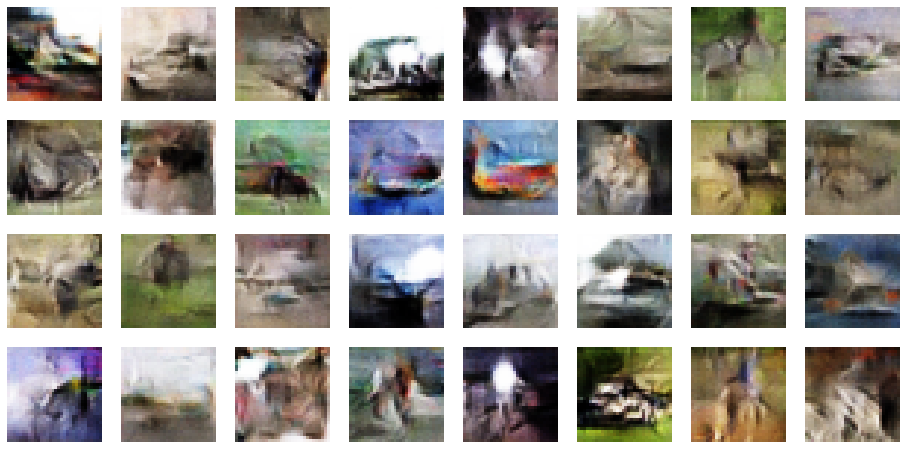

Epoch 19/20


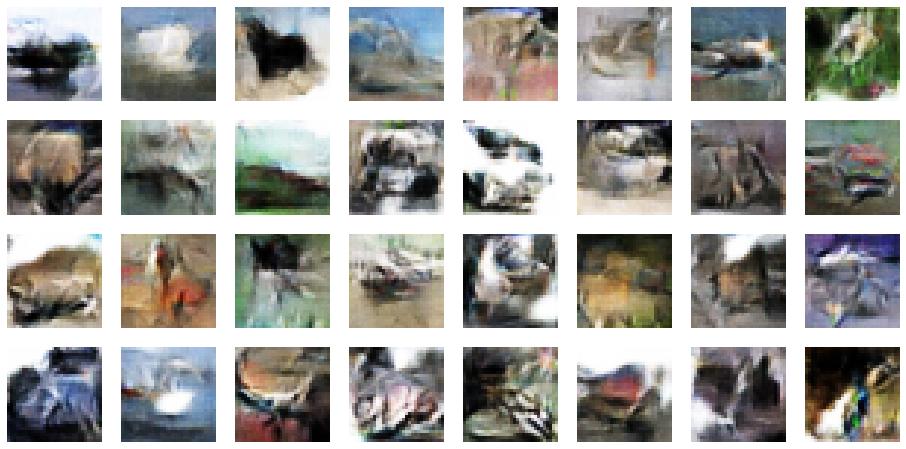

Epoch 20/20


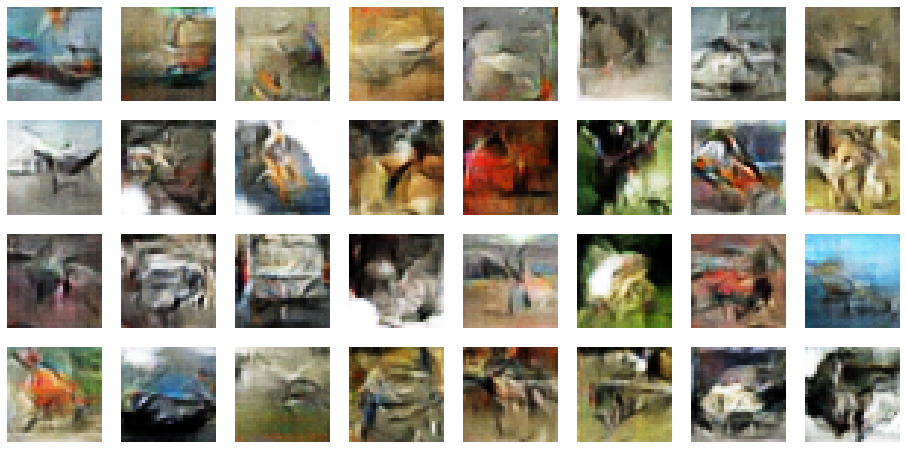

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=20)

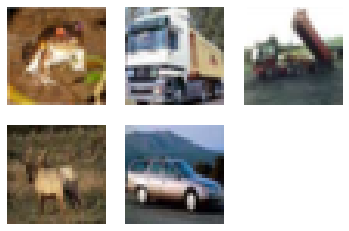

In [ ]:
plt.figure(figsize=(6, 4))
for index, image in enumerate(X_train[:5]):
    plt.subplot(2, 3, index  + 1)
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
plt.show()